## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1.)  Compute the camera calibration values using OpenCV's findChessboardCorners method

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

#Number of chessboard corners
nx = 9
ny = 6

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    cv2.drawChessboardCorners(img, (9, 6), corners, ret)
    new_fname = fname[:-4]
    plt.imsave(new_fname + '_corners.png', img)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
        
# Step through the list again and undistort the images
for fname2 in images:
    new_fname2 = fname2[:-4]
    image = cv2.imread(fname2)
    corners_image = cv2.imread(new_fname2 + '_corners.png')
    
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    corners_dst = cv2.undistort(corners_image, mtx, dist, None, mtx)
    
    plt.imsave(new_fname2 + '_dst.png', dst)
    plt.imsave(new_fname2 + '_dst_corners.png', corners_dst)

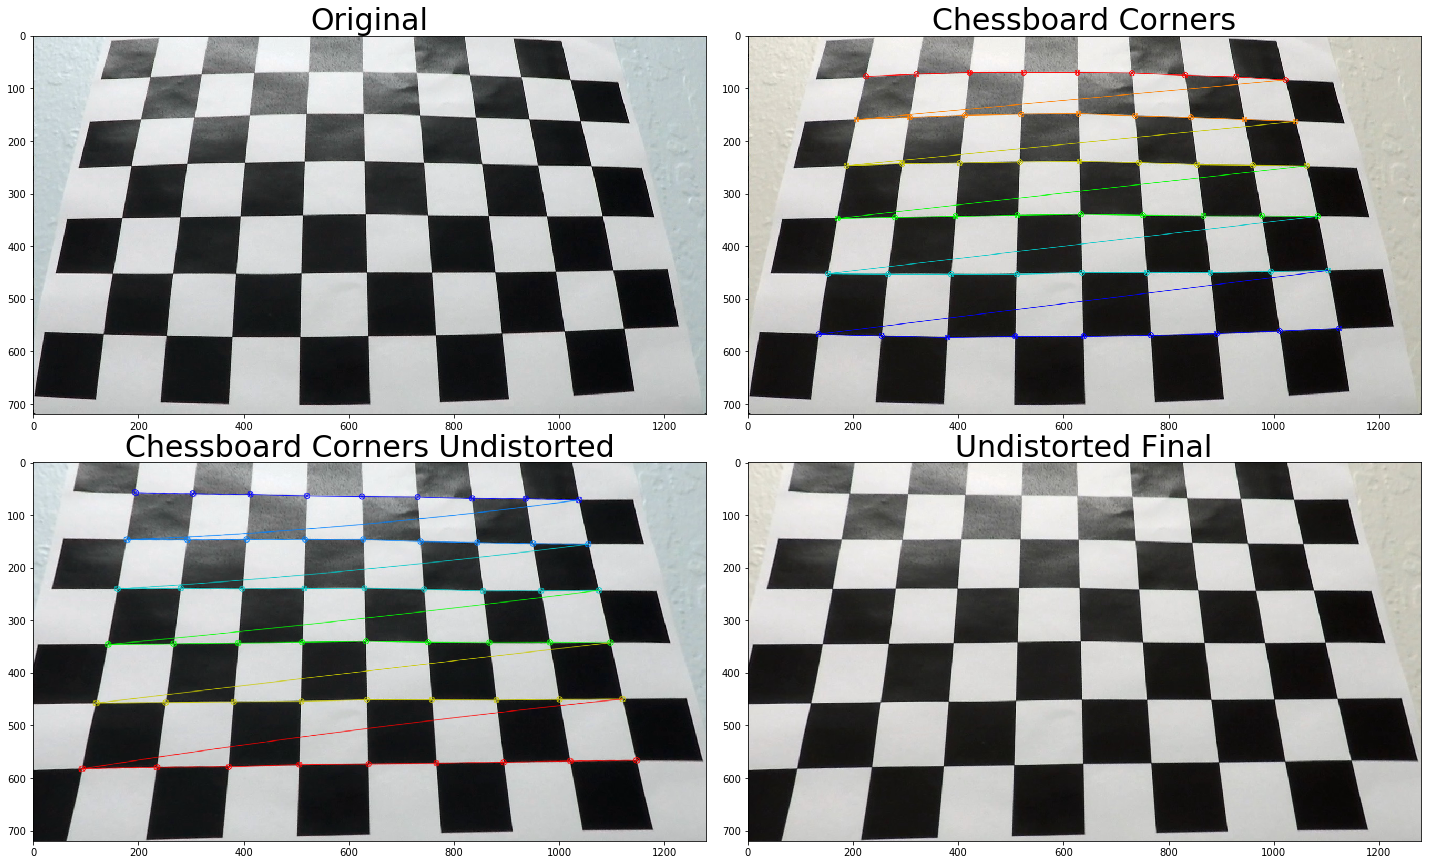

In [3]:
#Display the steps of undistortion using chessboard example

filename = '../camera_cal/calibration3'

cal3_original = cv2.imread(filename + '.jpg')
cal3_corners = cv2.imread(filename + '_corners.png')
cal3_corners_dst = cv2.imread(filename + '_dst_corners.png')
cal3_dst = cv2.imread(filename + '_dst.png')

a, ((chess1, chess2), (chess3, chess4)) = plt.subplots(2, 2, figsize = (20, 12))
a.tight_layout()

chess1.imshow(cal3_original)
chess1.set_title("Original", fontsize = 30)
chess2.imshow(cal3_corners)
chess2.set_title("Chessboard Corners", fontsize = 30)
chess3.imshow(cal3_corners_dst)
chess3.set_title("Chessboard Corners Undistorted", fontsize = 30)
chess4.imshow(cal3_dst)
chess4.set_title("Undistorted Final", fontsize = 30)

## 2.) Define functions to be used in the pipeline

In [4]:
#Function uses hue and saturation values to find yellow-ish pixels
def yellow_thresh(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    s = hls[:,:,2]
    binary = np.zeros_like(h)
    binary[(h >= 15) & (h <= 25) & (s >= 125)] = 1
    return binary

#White lane lines are easily found using the HLS lightness filter
def white_thresh(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1]
    binary = np.zeros_like(l)
    binary[(l >= 220)] = 1
    return binary

#Taken from project 1, returns overlay of two images
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

#Taken from Udacity lesson "Advanced Techniques for Lane Finding"
#Sections 33 & 35 "Finding the Lines" and "Measuring Curvature"
#Slight modifications made in order to overlay the lane with a green mask
#As well as to output the radius and off-center measurements
def draw_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    #Using the same syntax as the original code from the lesson
    #But instead of overlaying each line, I overlayed the road
    #between the two polynomial segments
    window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    window = np.hstack((window1, window2))
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([window]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Using half the width of the image as the center point
    #Finding the midpoint between the left and right lines
    #And taking the absolute distance from the center of the image
    width_pixel = np.abs(640 - np.mean([np.min(right_fitx), np.min(left_fitx)]))
    
    #Convert pixel distance to meters
    width = width_pixel * xm_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    #Take the average of the two line curves
    radius = np.mean([left_curverad, right_curverad])
    
    return result, radius, width

#For visualizing the sliding window approach
def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img1 = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img1,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img1,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img1, out_img2, left_fitx, right_fitx, ploty

## 3.) Pipeline to convert raw video frames into undistorted annotated images

In [5]:
def pipeline(img):

    #Undistort using our global undistortion values
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    #Region of interest
    #To be used in "birds-eye" perspective transform
    pts1 = np.float32([[540, 450], [740, 450], [100, 720], [1180, 720]])
    pts2 = np.float32([[0, 0], [1280, 0], [300, 720], [980, 720]])

    #Get perspective transform
    #Output should look as though the image was taken from above
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst2 = cv2.warpPerspective(dst, M, (1280, 720))

    #Looking for yellow and white lines        
    white = white_thresh(dst2)
    yellow = yellow_thresh(dst2)

    #Creating a blank image the same dimensions as our video
    binary = np.zeros_like(white)
    
    #If a pixel was found to be part of a yellow or white line
    #Light up that pixel
    binary[(yellow == 1) | (white == 1)] = 255

    #Function looks for nonzero pixels on the left and right side
    #It uses them to create an order two polynomial fit
    #Using the polynomial, we can also calculate curve radius
    #As well as distance from the center of the lane
    lines, radius, width = draw_lines(binary)
    
    #Display radius in kilometers and round it to one decimal place
    radius /= 1000
    radius = np.around(radius, decimals = 1)
    
    #Display off-center measure in meters, rounded to one decimal place
    width = np.around(width, decimals = 1)
    
    #To be drawn onto the output image
    radius_string = 'Radius of curve = ' + str(radius) + ' km'
    width_string = 'Car is ' + str(width) + 'm off center'

    #Reversing the perspective transform to give us our annotated image
    M_unwarp = cv2.getPerspectiveTransform(pts2, pts1)
    unwarped = cv2.warpPerspective(lines, M_unwarp, (1280, 720))
    weighted = weighted_img(unwarped, img)

    #Writing curve radius and distance from center on each frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(weighted, radius_string, (100, 100), font, 2, (255, 0, 255), 4, cv2.LINE_AA)
    cv2.putText(weighted, width_string, (100, 150), font, 2, (255, 0, 255), 4, cv2.LINE_AA)

    return weighted

## 4.) Visualization of pipeline steps

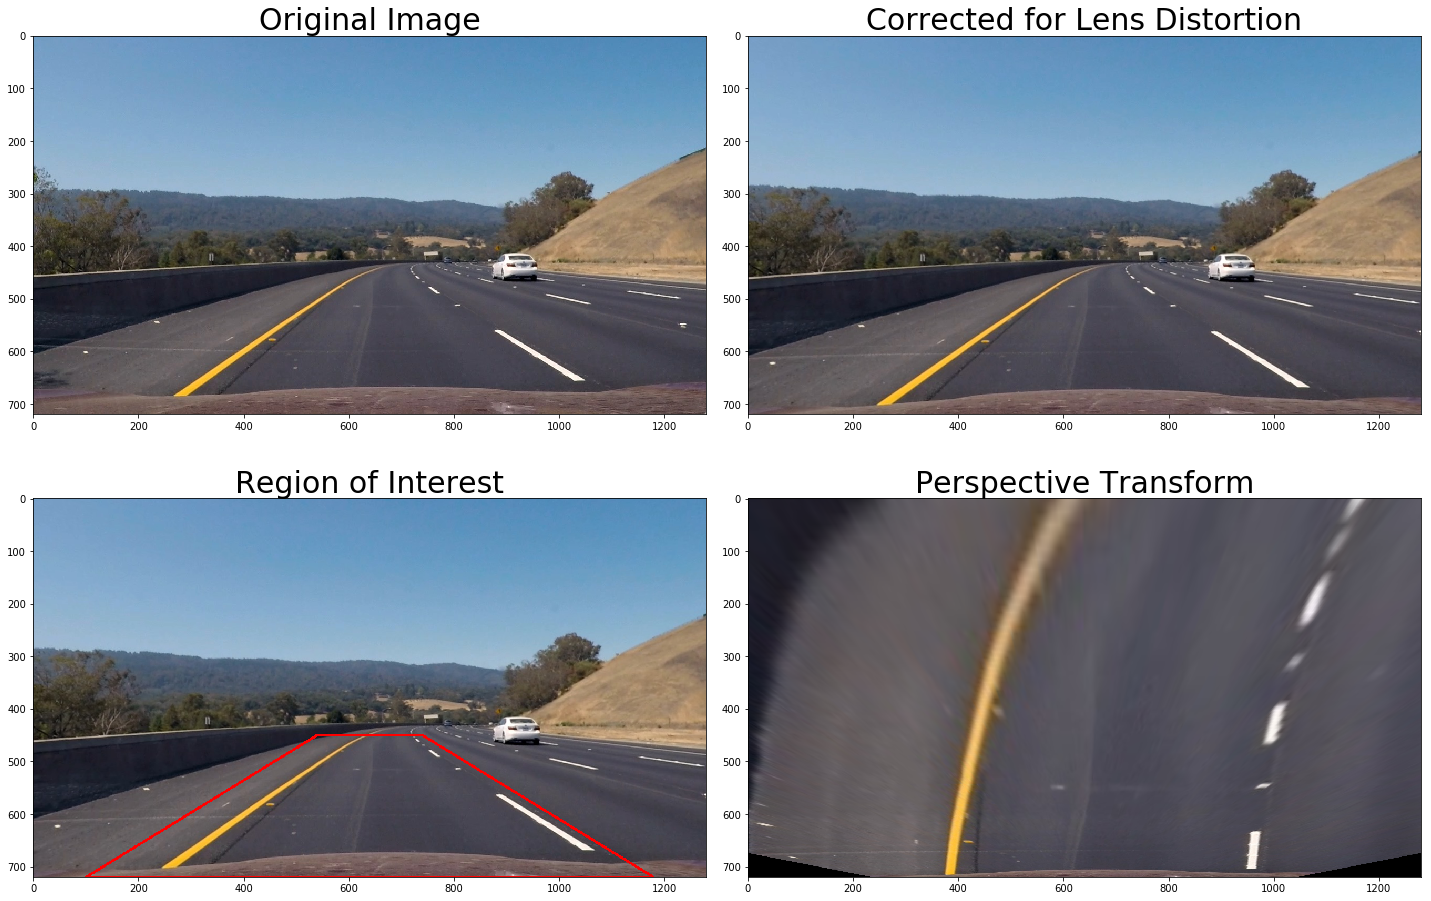

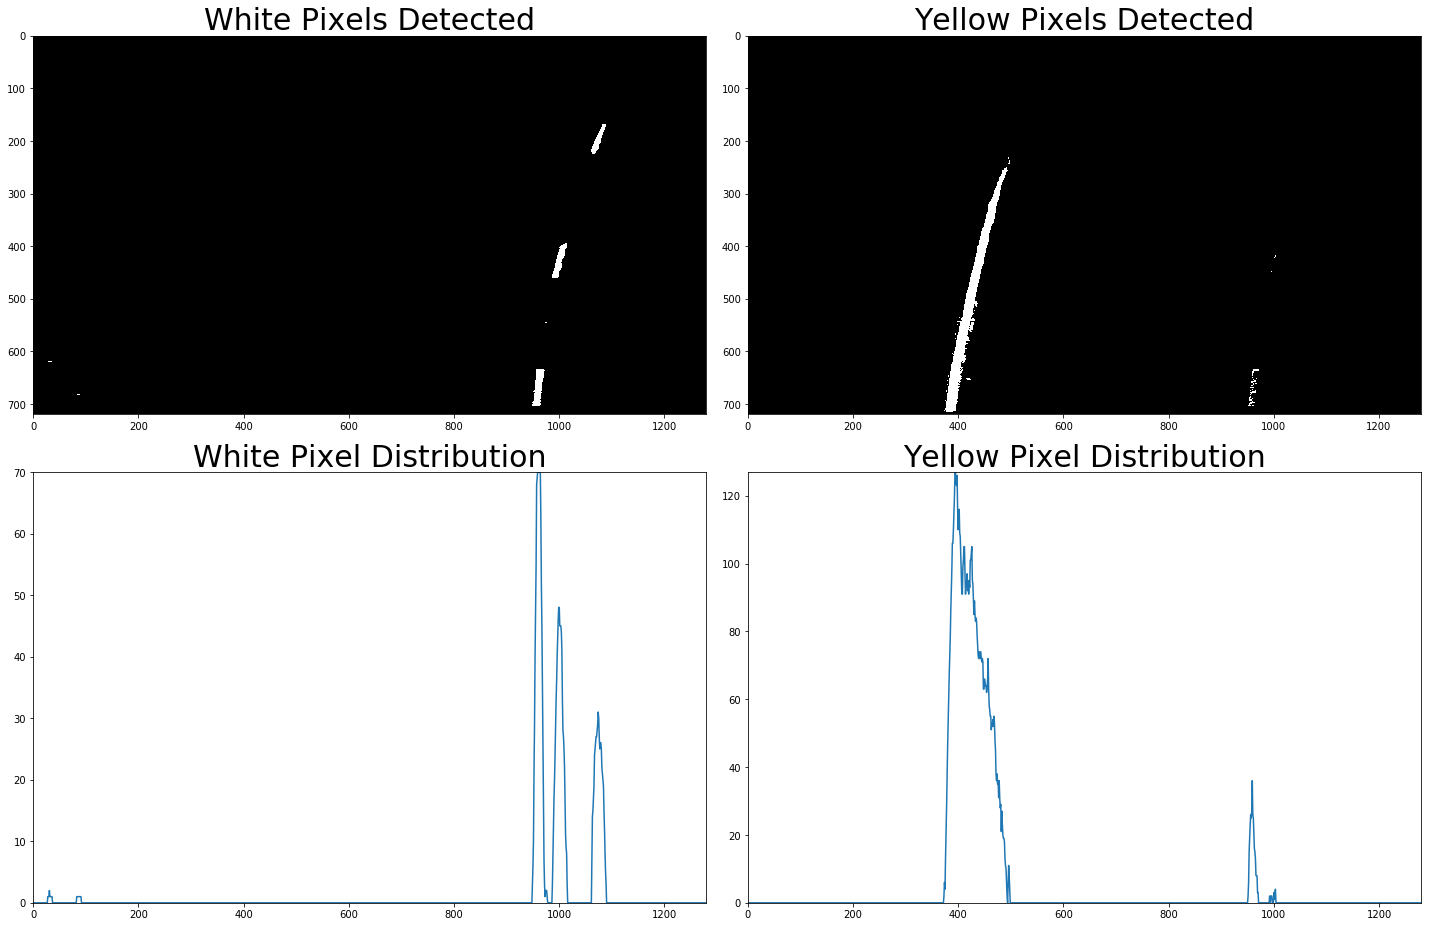

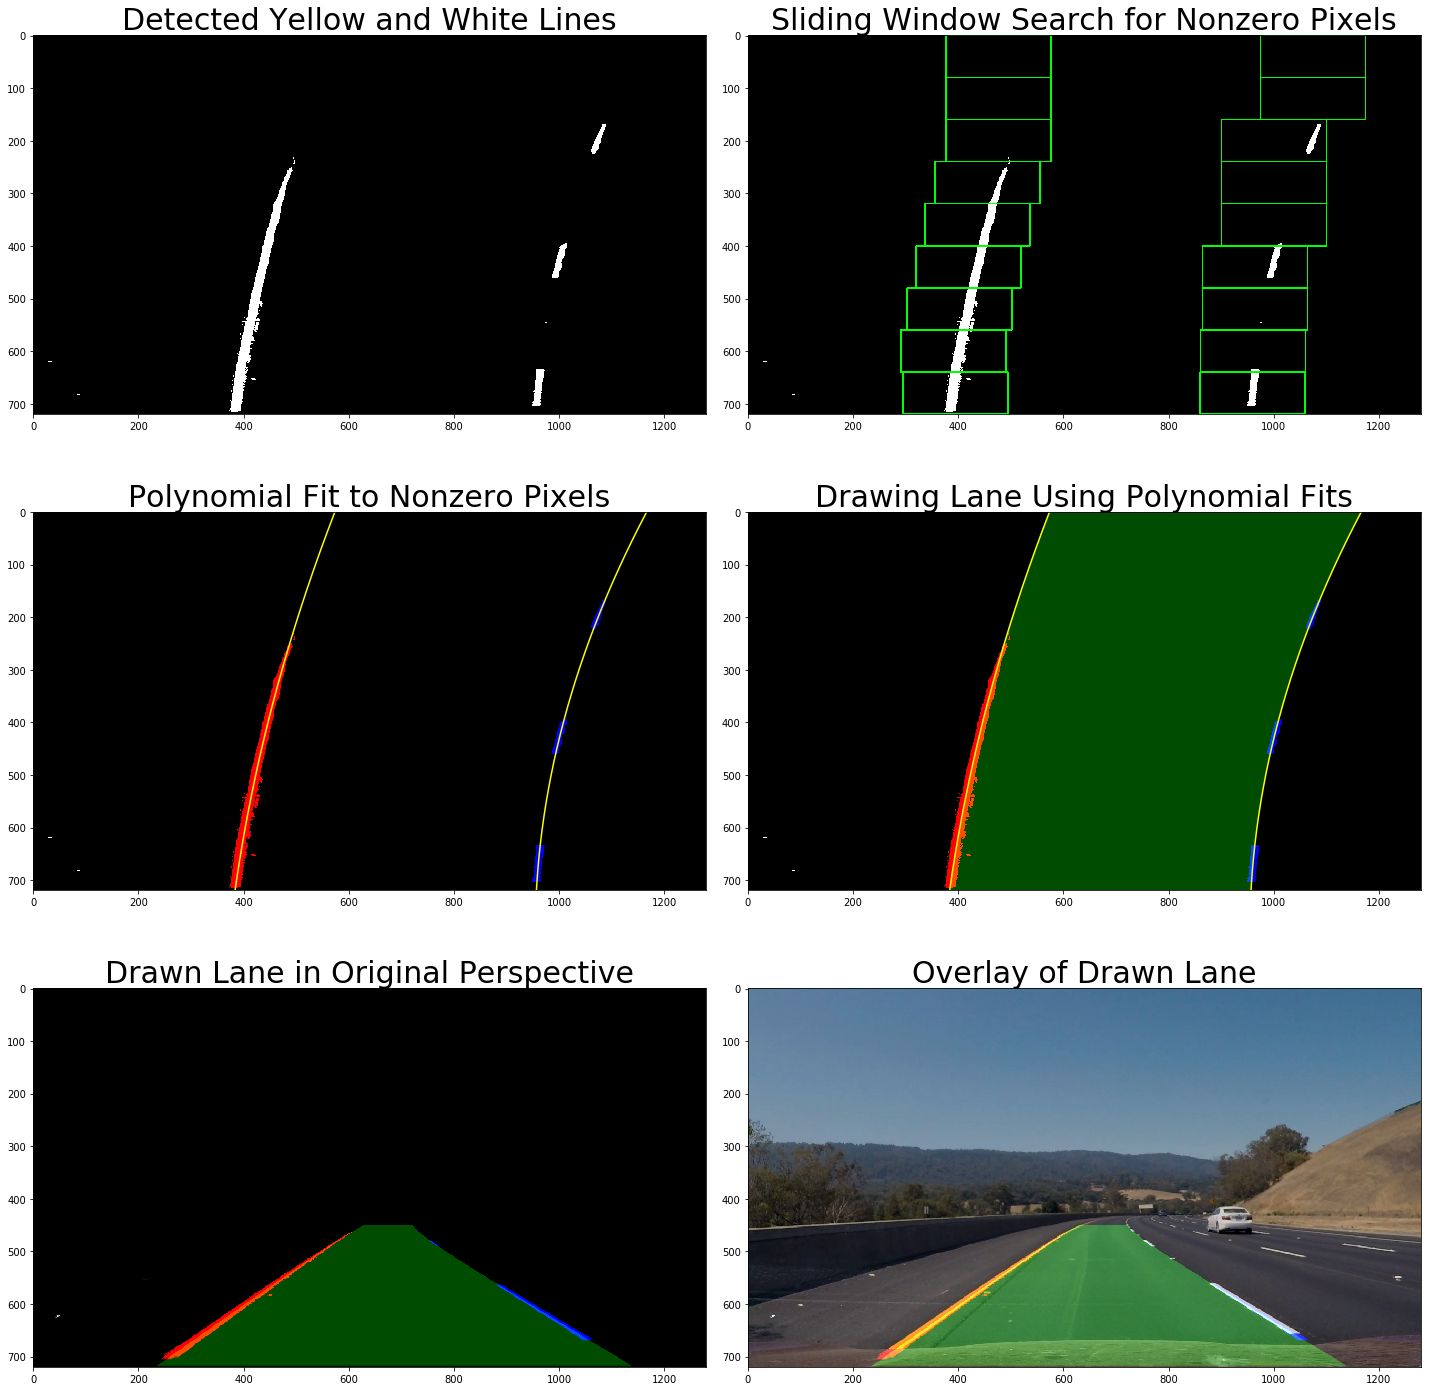

In [6]:
image = mpimg.imread('../test_images/test3.jpg')

#Undistort and display
dst = cv2.undistort(image, mtx, dist, None, mtx)
dst_1 = cv2.undistort(image, mtx, dist, None, mtx)
        
#Region of interest
pts1 = np.float32([[540, 450], [740, 450], [100, 720], [1180, 720]])
pts2 = np.float32([[0, 0], [1280, 0], [300, 720], [980, 720]])

polygon = [(540, 450), (740, 450), (1180, 720), (100, 720)]

#Get perspective transform
#Output should look as though the image was taken from above
M = cv2.getPerspectiveTransform(pts1, pts2)
dst2 = cv2.warpPerspective(dst, M, (1280, 720))


cv2.line(dst_1, polygon[0], polygon[1], (255, 0, 0), 3)
cv2.line(dst_1, polygon[1], polygon[2], (255, 0, 0), 3)
cv2.line(dst_1, polygon[2], polygon[3], (255, 0, 0), 3)
cv2.line(dst_1, polygon[3], polygon[0], (255, 0, 0), 3)

white = white_thresh(dst2)
yellow = yellow_thresh(dst2)

combined = np.zeros_like(white)
combined[(white == 1) | (yellow == 1)] = 1

window, colored_lines, left_fit, right_fit, ploty = sliding_window(combined)

histogram = np.sum(combined[:,:], axis = 0)
histogram_white = np.sum(white[:,:], axis = 0)
histogram_yellow = np.sum(yellow[:,:], axis = 0)

lane, curve_rad, off_center = draw_lines(combined)

overlay = weighted_img(lane, dst2)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (20, 13))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(dst, cmap = 'gray')
ax2.set_title('Corrected for Lens Distortion', fontsize=30)

ax3.imshow(dst_1, cmap = 'gray')
ax3.set_title('Region of Interest', fontsize=30)

ax4.imshow(dst2, cmap = 'gray')
ax4.set_title('Perspective Transform', fontsize=30)

f.savefig('figure1.png', bbox_inches = 'tight')

g, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize = (20, 13))
g.tight_layout()

ax5.imshow(white, cmap = 'gray')
ax5.set_title('White Pixels Detected', fontsize=30)

ax6.imshow(yellow, cmap = 'gray')
ax6.set_title('Yellow Pixels Detected', fontsize=30)

ax7.plot(histogram_white)
ax7.xlim = ((0, 1280))
ax7.margins(0)
ax7.set_title("White Pixel Distribution", fontsize=30)

ax8.plot(histogram_yellow)
ax8.xlim = ((0, 1280))
ax8.margins(0)
ax8.set_title("Yellow Pixel Distribution", fontsize=30)

g.savefig('figure2.png', bbox_inches = 'tight')

window, colored_lines, left_fit, right_fit, ploty = sliding_window(combined)

lane, rad, center = draw_lines(combined)

M_unwarp_lane = cv2.getPerspectiveTransform(pts2, pts1)
unwarped_lane = cv2.warpPerspective(lane, M_unwarp_lane, (1280, 720))
weighted_lane = weighted_img(unwarped_lane, image)

h, ((ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(3, 2, figsize = (20, 20))
h.tight_layout()

ax9.imshow(combined, cmap = 'gray')
ax9.set_title('Detected Yellow and White Lines', fontsize=30)

ax10.imshow(window, cmap = 'gray')
ax10.set_title('Sliding Window Search for Nonzero Pixels', fontsize=30)

ax11.imshow(colored_lines, cmap = 'gray')
ax11.plot(left_fit, ploty, color='yellow')
ax11.plot(right_fit, ploty, color='yellow')
ax11.set_title('Polynomial Fit to Nonzero Pixels', fontsize=30)

ax12.imshow(lane, cmap = 'gray')
ax12.plot(left_fit, ploty, color='yellow')
ax12.plot(right_fit, ploty, color='yellow')
ax12.set_title('Drawing Lane Using Polynomial Fits', fontsize=30)

ax13.imshow(unwarped_lane, cmap = 'gray')
ax13.set_title('Drawn Lane in Original Perspective', fontsize=30)

ax14.imshow(weighted_lane, cmap = 'gray')
ax14.set_title('Overlay of Drawn Lane', fontsize=30)

h.savefig('figure3.png', bbox_inches = 'tight')

## 5.) Using MoviePy and pipeline function to edit video

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
white_output = '../test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/project_video.mp4
[MoviePy] Writing video ../test_videos_output/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [05:01<00:00,  4.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/project_video.mp4 

Wall time: 5min 3s
